#**PyTorch Audio Emotion Classifier**

Presented by - 

Vamshi Krishna Reddy Kallem*- YS57416 [vamshik1@umbc.edu]





#Audio Classifier

Audio classification can be used to interpret audio scenario, which is critical in turn for an artificial entity to understand and communicate more efficiently with its environment. 

I'll create a classifier of audio emotions like anger, disgust, sad, joy, fear, surprise and neutral including gender categorising. Our primary goal is to have a dataset which comprises of audio files with above mentioned emotions of different gender  and age group. I have created a dataset with ~12500 audio files merging four different data files by labelling them into 7 different emotions of male and female (clearly explained below).


In [ ]:
# Installing relevant modules
!pip install torchaudio
!pip install pygame
!pip install pytorch-nlp

     |████████████████████████████████| 3.2MB 4.6MB/s 
     |████████████████████████████████| 11.4MB 268kB/s 
     |████████████████████████████████| 92kB 3.5MB/s 


In [ ]:
# Loading libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import IPython.display as ipd 
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

In [ ]:
# Additional libraries
import IPython.display as ipd
import pygame
import pygame.mixer
import torchaudio 
import torchnlp
from torchnlp.encoders import LabelEncoder
from collections import namedtuple
import random

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
#Changing device to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Importing dataset from drive
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Data 690 - project')

from mpdl import train_network, Flatten, weight_reset, View

I have worked with four different audio data sources.

##1.	Surrey Audio-Visual Expressed Emotion (SAVEE) - 

**Source** - http://kahlan.eps.surrey.ac.uk/savee/

**Size** - 110 MB

**Description** - 

Surrey Audio-Visual Expressed Emotion (SAVEE) database has been recorded as a pre-requisite for the development of an automatic emotion recognition system. The database consists of recordings from 4 male actors in 7 different emotions, 480 British English utterances in total. The sentences were chosen from the standard TIMIT corpus and phonetically-balanced for each emotion. The data were recorded in a visual media lab with high quality audio-visual equipment, processed and labeled. To check the quality of performance, the recordings were evaluated by 10 subjects under audio, visual and audio-visual conditions. 

The naming of the audio files is such that the prefix letters identify the groups of emotions as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

The original source has 4 files each representing a speaker, but I have packed them all into a single folder and thus the initials of the speaker are represented by the first 2 letter prefix of the filename. So, eg. 'DC d03.wav' is the third sentence of disgust spoken by the speaker DC. 

##2.	Toronto emotional speech set (TESS)  - 

**Source** - https://tspace.library.utoronto.ca/handle/1807/24487

**Size** - 440 MB

**Description** - 

The Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966) was the model of these stimuli. A set of 200 target words were spoken in the carrier phrase 'Say the word _ ' by two actresses (aged 26 and 64) and recordings were made of the series representing each of the seven emotions (anger, disgust, fear, joy, pleasant surprise, sadness, and neutral), with a total of 2800 stimuli.


##3.Crowd-Sourced Emotional Multimodal Actors (CREMA-D) -

**Source** - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4313618/

**Size** - 460 MB

**Description** - 

People express their facial and vocal emotional state. We present an audiovisual data collection specific for the study of speech and interpretation of multi-modal emotions. The data set consists of emotional facial and vocal expressions in sentences that are spoken in a variety of specific emotional states (happy, sad, rage, fear, disgust, and neutral). Multiple raters have rated 7,442 clips of 91 actors of diverse ethnic backgrounds in three modalities: audio, visual and audio-visual. Using crowd-sourcing from 2,443 raters, categorical emotion labels and real-value strength values were obtained for the perceived emotions.

Human recognition of intended emotion is 40.9 percent, 58.2 percent and 63.6 percent respectively for audio-only, visual-only, and audio-visual results. Rates of recognition are highest for neutral, followed by happiness, anger, disgust, fear and sadness. Average levels of emotional intensity are graded as highest for visual perception only. Recognizing disgust and fear correctly includes simultaneous audio-visual signals, whereas indignation and pleasure can be well identified based on data from a single modality. The broad dataset we are developing can be used to address other issues about the audiovisual experience of emotion.


##4.	The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)  -
**Source** - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4313618/

**Size** - 440 MB

**Description** - 

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. All conditions are available in three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).

# Loading dataset into dataframes

In all four datasets file name is the identifier of data characteristics like emotion, gender, speaker details, channel, etc. Parsing file name to label each file with emotion and gender as label. Path column with path of each file. 

###Parsing SAVEE data:

In [ ]:
SAVEE = "gdrive/My Drive/Data 690 - project/Savee/AudioData.zip (Unzipped Files)/AudioData/"
SAVEE_list = []
for root,dirname,filenames in os.walk(SAVEE):   
     for filename in filenames:
        SAVEE_list.append(str(root.split('/')[-1])+'_'+str(filename))

emotion=[]
path = []
for i in SAVEE_list:
  #print(i)
  if i[-8:-6]=='_a':
    emotion.append('male_angry')
  elif i[-8:-6]=='_d':
    emotion.append('male_disgust')
  elif i[-8:-6]=='_f':
    emotion.append('male_fear')
  elif i[-8:-6]=='_h':
    emotion.append('male_happy')
  elif i[-8:-6]=='_n':
    emotion.append('male_neutral')
  elif i[-8:-6]=='sa':
    emotion.append('male_sad')
  elif i[-8:-6]=='su':
    emotion.append('male_surprise')
  else:
    emotion.append('male_error') 
  path.append(SAVEE + i.split('_')[0]+'/'+i.split('_')[1])
    
    
# Now check out the label count distribution
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])],axis=1)
SAVEE_df['source'] = 'SAVEE'

In [ ]:
cols = ['source','labels','path']

In [ ]:
SAVEE_df = SAVEE_df[cols]

In [ ]:
SAVEE_df.head()

,source,labels,path
0,SAVEE,male_angry,gdrive/My Drive/Data 690 - project/Savee/Audio...
1,SAVEE,male_angry,gdrive/My Drive/Data 690 - project/Savee/Audio...
2,SAVEE,male_angry,gdrive/My Drive/Data 690 - project/Savee/Audio...
3,SAVEE,male_angry,gdrive/My Drive/Data 690 - project/Savee/Audio...
4,SAVEE,male_angry,gdrive/My Drive/Data 690 - project/Savee/Audio...


In [ ]:
len(SAVEE_df)

480

###Parsing RAVDESS data:

In [ ]:
RAV = "gdrive/My Drive/Data 690 - project/ravdess"
RAV_list = os.listdir(RAV)
emotion = []
gender = []
path = []
for i in RAV_list:
    #print(i)
    fname = os.listdir(RAV+'/'+i)
    #print(fname)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV +'/'+ i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS' 
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

In [ ]:
RAV_df = RAV_df[cols]

In [ ]:
RAV_df.path[0]

'gdrive/My Drive/Data 690 - project/ravdess/Actor_03/03-01-02-01-02-02-03.wav'

In [ ]:
len(RAV_df)

1440

###Parsing TESS data:

In [ ]:
TESS = "gdrive/My Drive/Data 690 - project/TESS/TESS Toronto emotional speech set data/"
TESS_list = os.listdir(TESS)
print(TESS_list)
path = []
emotion = []
for i in TESS_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)

['OAF_neutral', 'OAF_happy', 'OAF_angry', 'OAF_Sad', 'OAF_disgust', 'YAF_angry', 'OAF_Pleasant_surprise', 'OAF_Fear', 'YAF_disgust', 'YAF_neutral', 'YAF_fear', 'YAF_pleasant_surprised', 'YAF_sad', 'YAF_happy']


In [ ]:
TESS_df = TESS_df[cols]

In [ ]:
TESS_df.path[0]

'gdrive/My Drive/Data 690 - project/TESS/TESS Toronto emotional speech set data/OAF_neutral/OAF_back_neutral.wav'

In [ ]:
len(TESS_df)

2798

###Parsing CREMA-D data:

In [ ]:
CREMA = "gdrive/My Drive/Data 690 - project/cremad/AudioWAV/"
CREMA_list = os.listdir(CREMA)
#print(CREMA_list)
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in CREMA_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

In [ ]:
CREMA_df = CREMA_df[cols]

In [ ]:
len(CREMA_df)

7442

###Concatinating all Four DataFrames:

In [ ]:
Audio_Emotion = pd.concat([SAVEE_df,RAV_df,TESS_df,CREMA_df], ignore_index=True)

In [ ]:
Audio_Emotion.labels[0]

'male_angry'

In [ ]:
len(Audio_Emotion)

12160

In [ ]:
Audio_Emotion.shape

(12160, 4)


Few key concepts about audio file.

1. **Duration** -  is the length of the audio in terms of time.

2. **Sampling rate** - is the number of audio samples per second, expressed in Hz / KHz. This is close to that of image size, where the higher the size (or more pixels), the clearer it is. A maximum sampling rate is 44100 Hz (44.1 KHz), but in 'High Fidelity' mode, you don't necessarily need to have it. A more appropriate sampling rate is 22050 Hz (22 KHz), because this is a human's audible sound.

3. **Amplitude** - is the variation of the soud wave. The shorter the waves are, and the higher the pitch or frequency. The most intuitive way of interpreting the audio is possibly to map the audio against amplitude by time. It's not, however, the only way of representing the data or using it as function. Another equally good way to do that is to look at it from the frequency domain, which is a pleasant segway to our final definition.


4. **Frequency** - The easiest way to grasp this is by visualizing it. The most intuitive way of thinking about it possibly is to picture the audio in terms of time. But frequency, while not as intuitive, is actually much more effective as signal needs far less computational storage space in the frequency domain. Below is a good view of how to distinguish the Domain Time vs Frequency.



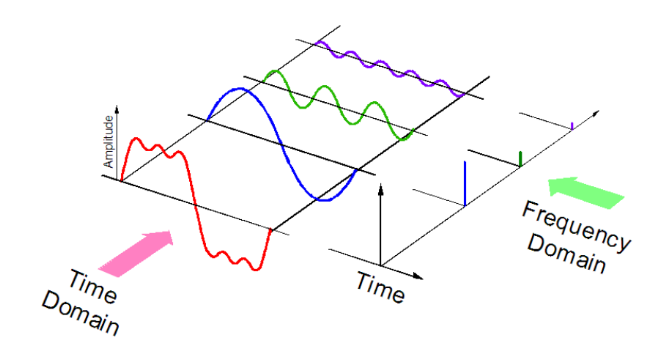


There are 2 category of features:

**Time domain features**-

These are easier to isolate and understand, such as signal energy, zero crossing rate, max amplitude, minimum energy, etc.

Time domain extraction techniques
1. Audio wave


**Frequency based features**-

These are obtained by translating the signal to the frequency domain dependent on time. Although they are more difficult to comprehend, it offers additional details that can be useful including pitch, rhythms, melody, etc. 

Frequency domain extraction techniques
1. MFCC
2. Log Mel-spectogram
3. Harmonic-percussive source separation (HPSS)
4. Chroma


Check this infographic below:


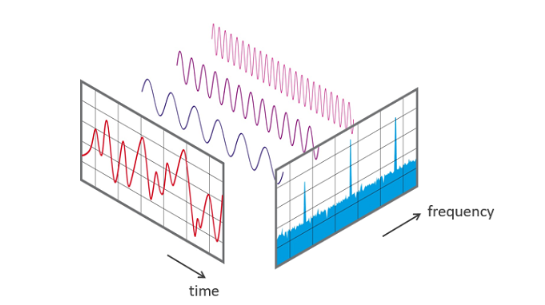




#Data Exploration-

In [ ]:
## data_load function is to load audio file and return waveform and sample rate using torchaudio.load class. 
def data_load(filename):
  filename=filename
  waveform, sample_rate = torchaudio.load(filename)
  return waveform , sample_rate

###Visualizing Class distribution in all DataSet


In [ ]:
# Class classification based on waveform shape and sample rate
#Ravdess dataset 
RAV_df['Waveform']=[data_load(i)[0].shape[1]/data_load(i)[1] for i in RAV_df['path']]
Rav_class_dict=RAV_df.groupby(['labels'])['Waveform'].mean()

In [ ]:
#Crema dataset 
CREMA_df['Waveform']=[data_load(i)[0].shape[1]/data_load(i)[1] for i in CREMA_df['path']]
crema_class_dict=RAV_df.groupby(['labels'])['Waveform'].mean()

In [ ]:
#Tess dataset 
TESS_df['Waveform']=[data_load(i)[0].shape[1]/data_load(i)[1] for i in TESS_df['path']]
tess_class_dict=TESS_df.groupby(['labels'])['Waveform'].mean()

In [ ]:
#Savee dataset 
SAVEE_df['Waveform']=[data_load(i)[0].shape[1]/data_load(i)[1] for i in SAVEE_df['path']]
savee_class_dict=SAVEE_df.groupby(['labels'])['Waveform'].mean()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]

fig = make_subplots(rows=2, cols=2, specs= specs)

# Create subplots: use 'domain' type for Pie subplot
fig.add_trace(go.Pie(labels=savee_class_dict.index, values=savee_class_dict, name="SAVEE"),1, 1)
fig.add_trace(go.Pie(labels=tess_class_dict.index, values=tess_class_dict, name="TESS"),1, 2)
fig.add_trace(go.Pie(labels=Rav_class_dict.index, values=Rav_class_dict, name="RAVDESS"),2, 1)
fig.add_trace(go.Pie(labels=crema_class_dict.index, values=crema_class_dict, name="CREMA-D"),2, 2)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_text="Class Distribution in different Datasets",
    titlefont= {"size": 36},
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='SAVEE',x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='TESS',x=0.82, y=0.5, font_size=20, showarrow=False),
                 dict(text='RAVDESS',x=0.18, y=-0.1, font_size=20, showarrow=False),
                 dict(text='CREMA-D',x=0.82, y=-0.1, font_size=20, showarrow=False)])
fig.show()

#https://plotly.com/python/pie-charts/
#https://community.plotly.com/t/change-title-size-and-make-bold/1728/3
#https://www.youtube.com/watch?v=mUXkj1BKYk0&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P&index=3

###Visualizing MFCC for few of the labels by selecting random audio files from random dataset

In [ ]:
#Taking tess data for instance to represent different mfcc for different labels
mfcc_tess_df=(TESS_df.groupby('labels').apply(lambda df: df.sample(1)))
#mfcc_audio_list=list(mfcc_tess_df.path)
#mfcc_audio_label=list(mfcc_tess_df.labels)
#https://stackoverflow.com/questions/38390242/sampling-one-record-per-unique-value-pandas-python

In [ ]:
#Playing audio
for i in range(mfcc_tess_df.shape[0]):
  print(mfcc_tess_df.labels[i])
  ipd.display(ipd.Audio(mfcc_tess_df.path[i]))
#https://stackoverflow.com/questions/54417598/playing-audio-in-jupyter-in-a-for-loop

female_angry


female_disgust


female_fear


female_happy


female_neutral


female_sad


female_surprise


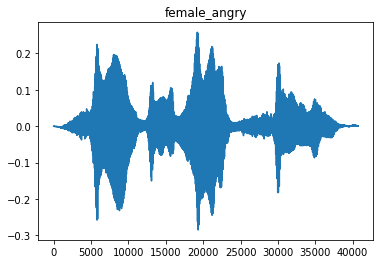

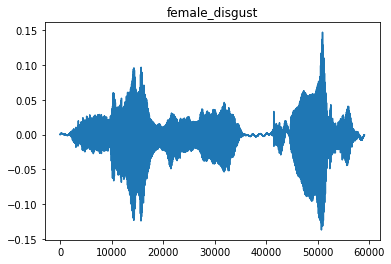

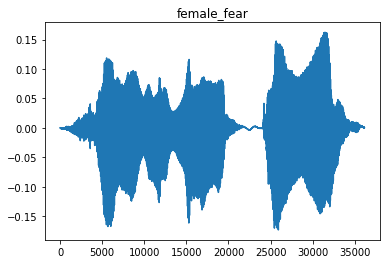

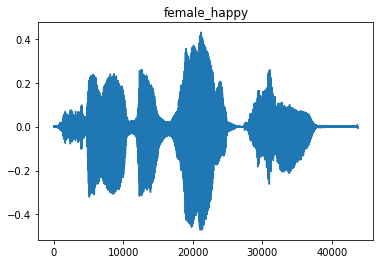

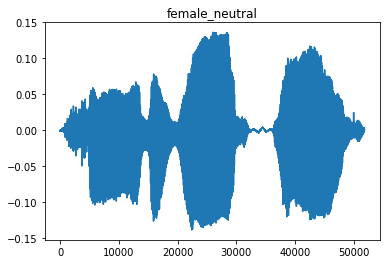

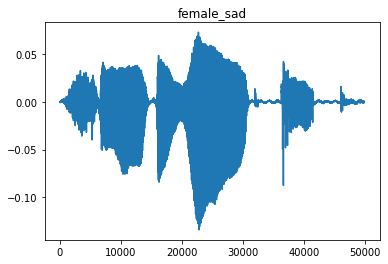

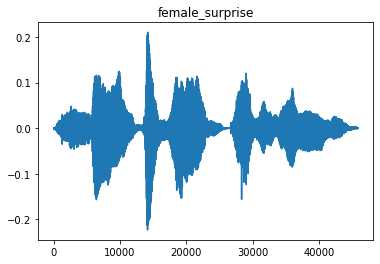

In [ ]:
#Visualizing audiowave
for i in range(mfcc_tess_df.shape[0]):
  plt.figure()
  plt.plot(data_load(mfcc_tess_df.path[i])[0].t().numpy())
  plt.title(mfcc_tess_df.labels[i])

These are time series representation of all the different classes. From the plots above , all the data seems clear as there is not many low magnitude portion. This tells us there are not many dead spaces in our audio files and these files can be used for algorithm.

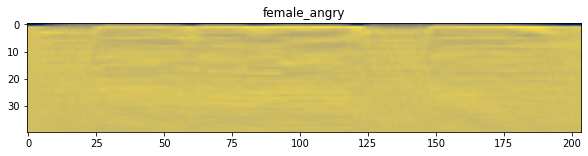

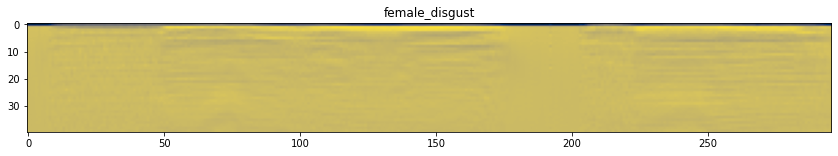

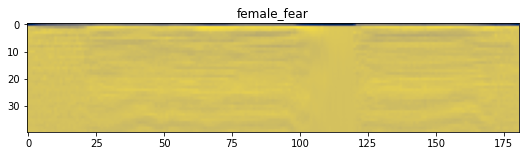

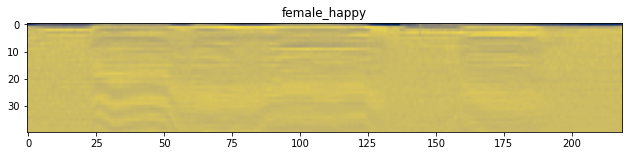

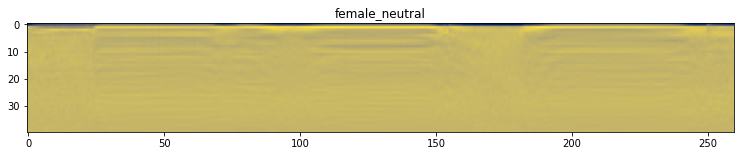

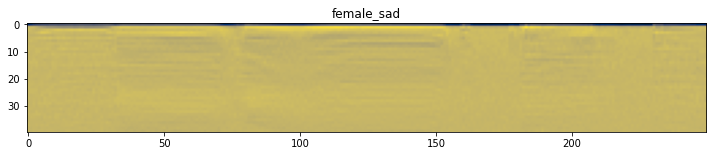

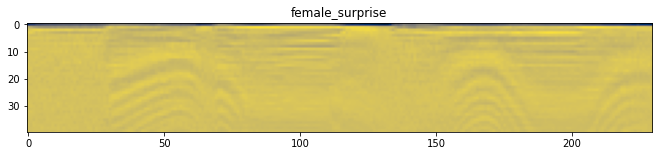

In [ ]:
#Visualizing MFCC
for i in range(mfcc_tess_df.shape[0]):
  plt.figure(figsize=(15,2))
  mfcc=torchaudio.transforms.MFCC()(data_load(mfcc_tess_df.path[i])[0])
  plt.imshow(mfcc.squeeze(), cmap='cividis')
  plt.title(mfcc_tess_df.labels[i])
  #.T.squeeze().t().numpy()


From above plots, we can see the shape of an MFCC output for each file, and it's a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, representing the MFCC bands over time. 

So if you look at the above MFCC plot, the last band at the bottom with label 'female surprise' is the most distinctive band over the other bands. Since the time window is a short one, the changes observed overtime does not vary greatly. 

#Label Encoding -

**LabelEncoder** encodes labels with a value between 0 and n classes-1, where n is the number of labels which are distinct. If a mark repeats it is assigning the same value as previously assigned. The categorical values were converted into numeric values. That is all about mark encoding

In [ ]:
#Carrying unique labels into samples
samples = list(Audio_Emotion.labels.unique())
len(samples)

14

In [ ]:
#Encoding labels using torch nlp LabelEncoder
encoder = LabelEncoder(samples, reserved_labels=['unknown'], unknown_index=0)

In [ ]:
#Carrying out encoded label in another column
Audio_Emotion['labels_encoded']=""

for i in range(len(Audio_Emotion.labels)):
  Audio_Emotion['labels_encoded'][i]=(encoder.encode(Audio_Emotion.labels[i]))

In [ ]:
Audio_Emotion.sample(5)

,source,labels,path,labels_encoded
9094,CREMA,male_neutral,gdrive/My Drive/Data 690 - project/cremad/Audi...,tensor(5)
585,RAVDESS,male_surprise,gdrive/My Drive/Data 690 - project/ravdess/Act...,tensor(7)
3545,TESS,female_disgust,gdrive/My Drive/Data 690 - project/TESS/TESS T...,tensor(13)
2440,TESS,female_angry,gdrive/My Drive/Data 690 - project/TESS/TESS T...,tensor(11)
2102,TESS,female_neutral,gdrive/My Drive/Data 690 - project/TESS/TESS T...,tensor(8)


[Microsoft Azure torchaudio Tutorial](https://notebooks.azure.com/pytorch/projects/tutorials/html/beginner/audio_preprocessing_tutorial.ipynb)

Understanding Transformations

#Feature Extraction-


**torchaudio.load()**-
Loads an audio file from disk into a tensor.

It has below parameters-


1. *filepath (str or pathlib.Path):* Path to audio file

2. *out (torch.Tensor, optional):* An output tensor to use instead of creating one. (Default: ``None``)

3. *normalization (bool, number, or callable, optional):* normalization (bool, number, or callable, optional): If boolean `True`, then output is divided by `1 << 31`(assumes signed 32-bit audio), and normalizes to `[-1, 1]`.If `number`, then output is divided by that number. If `callable`, then the output is passed as a parameter to the given function, then the output is divided by result. (Default: ``True``)


In [ ]:
#Loading .wav files
waveform,sr= torchaudio.load(Audio_Emotion.path[100],out = None, normalization = True)
y=os.path.getsize(Audio_Emotion.path[100])
y

549214

In [ ]:
print(waveform.shape)
print(waveform)

torch.Size([1, 274585])
tensor([[0.0505, 0.0504, 0.0504,  ..., 0.0391, 0.0391, 0.0392]])


Downsampling helps reducing data size, compress. One of the methods to do so is Resample.

**Resample** a signal from one frequency to another. A resampling method can be given.

Parameters-
1. *orig_freq (float, optional)* – The original frequency of the signal. (Default: 16000)
2. *new_freq (float, optional)* – The desired frequency. (Default: 16000)
3. *resampling_method (str, optional)* – The resampling method. (Default: 'sinc_interpolation')

In [ ]:
#Using resampling method
new_sample_rate = sr/10
channel = 0
resample = torchaudio.transforms.Resample(sr, new_sample_rate)((waveform)[channel,:].view(1,-1))
print(resample.shape)


torch.Size([1, 27459])


A **Mel Spectrogram** is a spectrogram where the frequencies are converted to the mel scale

Paramters- 
1. *sample_rate (int, optional)* – Sample rate of audio signal. (Default: 16000)
2. *win_length (int or None, optional)* – Window size. (Default: n_fft)
3. *hop_length (int or None, optional)* – Length of hop between STFT windows. (Default: win_length // 2)
4. *n_fft (int, optional)* – Size of FFT, creates n_fft // 2 + 1 bins. (Default: 400)
5. *f_min (float, optional)* – Minimum frequency. (Default: 0.)
6. *f_max (float or None, optional)* – Maximum frequency. (Default: None)
7. *pad (int, optional)* – Two sided padding of signal. (Default: 0)
8. *n_mels (int, optional)* – Number of mel filterbanks. (Default: 128)
9. *window_fn (Callable[.., Tensor], optional)* – A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
10. *wkwargs (Dict[.., ..] or None, optional)* – Arguments for window function. (Default: None)

In [ ]:
#Using  MelSpectrogram method

MELSpec = torchaudio.transforms.MelSpectrogram()(resample)
print(MELSpec.shape)

torch.Size([1, 128, 138])


**AmplitudeToDB** turns a tensor from the power/amplitude scale to the decibel scale.

Parameters-
1. *stype (str, optional)* – scale of input tensor (‘power’ or ‘magnitude’). The power being the elementwise square of the magnitude. (Default: 'power')

2. *top_db (float, optional)* – minimum negative cut-off in decibels. A reasonable number is 80. (Default: None)

In [ ]:
#Using AmplitudeToDB method
Auto = torchaudio.transforms.AmplitudeToDB()(MELSpec)
print(Auto.shape)


torch.Size([1, 128, 138])


**MFCC** is well known to be a good feature.  It stands for **Mel-frequency cepstral coefficient**, and it is a good "representation" of the vocal tract that produces the sound which look like an x-ray of your mouth.

The application for machine learning treats the MFCC itself as a 'image,' and becomes a function. The benefit of treating it as an picture is it provides more detail, and it gives one the opportunity to draw on learning transfer. This is certainly legit and gives strong precision. Research has also shown, however, that statistics related to MFCCs (or any other time or frequency domain) can also hold a good amount of information.

Parameters-

1. *sample_rate (int, optional)* – Sample rate of audio signal. (Default: 16000)

2. *n_mfcc (int, optional)* – Number of mfc coefficients to retain. (Default: 40)

3. *dct_type (int, optional)* – type of DCT (discrete cosine transform) to use. (Default: 2)

4. *norm (str, optional)* – norm to use. (Default: 'ortho')

5. *log_mels (bool, optional)* – whether to use log-mel spectrograms instead of db-scaled. (Default: False)

6. *melkwargs (dict or None, optional)* – arguments for MelSpectrogram. (Default: None)

In [ ]:
#Using MFCC method
MFCC = torchaudio.transforms.MFCC()(resample)
print(MFCC.shape)

torch.Size([1, 40, 138])


# PyTorch Data Generator:


### Data Splitting:

In [ ]:
#Using sklearn train_test_split to split data in train and testing set
x_train, x_test, y_train, y_test= train_test_split(Audio_Emotion.path,Audio_Emotion.labels_encoded, test_size=0.25) 

In [ ]:
x_train = list(x_train)
x_test = list(x_test)
y_train = list(y_train)
y_test = list(y_test)
print(len(x_train))

9120


### Formatting Data:

In [ ]:
class Audio_Dataset(Dataset):
  def __init__(self, PATH , LABELS):
    'Initialization'
    self.labels = LABELS
    self.path = PATH
    
  def __len__(self):
    'Denotes the total number of samples'
    return len(self.path)

  def __getitem__(self, index):  
    'Generates one sample of data'
    # Select sample
    ID = self.path[index]
    counter=0
    #carrying out waveform and sample rate of audio files. Torch audio will provide list of tensor files
    waveform , sample_rate = torchaudio.load(ID, out = None, normalization = True) 
    #resampling signal default frequency to low frequency to its 1/10th
    new_sample_rate = sample_rate/10
    channel = 0
    resample_wave = torchaudio.transforms.Resample(sample_rate, new_sample_rate)((waveform)[channel,:].view(1,-1)) 

    MFCC = torchaudio.transforms.MFCC()(resample_wave)
    #Padding is performed to match size of all the tensors
    #Padding tensors to 0 whose number of values in tensor less than 6320(tensor with highest size)
    #Prof: you should have code that gets this max size programatically. Hard-coding is bad practice for something like that! Very easy to add new data / remove data and now its no longer a good number to use. 
    pad_seq = (0,int(6320/40-MFCC.numel()/40))
    pad_waveform = F.pad(MFCC,pad_seq,'constant',0)
        
    Audio_Tensors = pad_waveform
    Audio_labels = self.labels[ID]

    return Audio_Tensors, Audio_labels
    #return labels and tensor 


In [ ]:
#Creating a dictionary for train and test that carries path as key and labels as values
labelsDict_train = dict(zip(x_train, y_train))
labelsDict_test = dict(zip(x_test, y_test))

In [ ]:
#formatting dataset 
train_set = Audio_Dataset(x_train, labelsDict_train)
test_set = Audio_Dataset(x_test, labelsDict_test)

In [ ]:
# Setting parameters for dataloader
#num_workers-  to put data into RAM
#pin_memory - to speed up the host to device transfer
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu


#Creating dataloader 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

In [ ]:
#Setting number of classes as num of labels plus 1 because our label starts from 1 not from 0 and loader takes values in ranges.
NumClasses = 15

In [ ]:
model_CNN = nn.Sequential(
    nn.Conv2d(1,32,3,stride=2,padding=1), ## inshape(1,40,158)
    ## outshape(5,32,20,79)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2), ## outshape (5,32,10,39) 
    nn.Conv2d(32,32,3,stride=2,padding=1), ## outshape(5,32,5,20)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2),## outshape(5,32,2,10)
    nn.Flatten(),##shape(5,640)
    nn.Linear(640,128), # outshape(5,128)
    nn.Linear(128,15) ## (5,number of classes)
    )

In [ ]:
#Why CrossEntropyLoss() - Cross-entropy loss, measures the performance of a classification model whose output is a probability value between 0 and 1. 
#Cross-entropy loss increases as the predicted probability diverges from the actual label.
loss_func = nn.CrossEntropyLoss()

In [ ]:
Model_=train_network(model_CNN,loss_func,train_loader,test_loader,epochs=10,
                     score_funcs={'Accuracy': accuracy_score},
                     device = device)

In [ ]:
Model_

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,4485.829237,21243.379639,21243.379639,0.203509,0.310197
1,1,6200.078556,16693.103436,16693.103436,0.382127,0.407895
2,2,7946.795925,14293.054630,14293.054630,0.473575,0.467105
3,3,9642.304387,12955.804420,12955.804420,0.502303,0.481579
4,4,11338.218306,12042.887894,12042.887894,0.534868,0.498355
5,5,13039.377811,11417.323772,11417.323772,0.555482,0.491776
6,6,14791.087085,10815.087116,10815.087116,0.574123,0.507895
7,7,16536.715302,10435.800274,10435.800274,0.591338,0.527632
8,8,18275.104772,10152.790222,10152.790222,0.602632,0.536842
9,9,20036.615215,9696.008560,9696.008560,0.622697,0.551974


We got 62% accuracy with our Model_ but we could achieve more accuracy if we increase more epochs and loss could be reduced as well.

That said, your model was doing decently, and you are correct the accuract would likely increase if you trained for longer. 

#Carryout out predictions

For predictions, we are carrying out random audio files created by us manually and making predictions on that.

In [ ]:
#Loading audio files for prediction
prediction_path = "gdrive/My Drive/Data 690 - project/prediction/"
prediction_list = os.listdir(prediction_path)
print(prediction_list)
prediction_files = []
for i in prediction_list:
  prediction_files.append(prediction_path + i)
prediction_files

['Wow.wav', 'sammy.wav', 'calm.wav']


['gdrive/My Drive/Data 690 - project/prediction/Wow.wav',
 'gdrive/My Drive/Data 690 - project/prediction/sammy.wav',
 'gdrive/My Drive/Data 690 - project/prediction/calm.wav']

In [ ]:

def Prediction(path):

  #Converting prediction wav of one file path[2] to tensors
  #carrying out waveform and sample rate of audio files. Torch audio will provide list of tensor files
  waveform , sample_rate = torchaudio.load(path, out = None, normalization = True) 

  #resampling signal default frequencyto low frequency to its 1/10th
  new_sample_rate = sample_rate/10
  channel = 0
  resample_wave = torchaudio.transforms.Resample(sample_rate, new_sample_rate)((waveform)[channel,:].view(1,-1)) 
  #print(resample_wave.shape)
  MFCC = torchaudio.transforms.MFCC()(resample_wave)
      
  #Padding is performed to match size of all the tensors
  #Padding tensors to 0 whose number of values in tensor less than 6320(tensor with highest size)
  pad_seq = (0,int(6320/40-MFCC.numel()/40))
  pad_waveform = F.pad(MFCC,pad_seq,'constant',0)
          
  prediction_Audio_Tensors = pad_waveform
  prediction_Audio_Tensors=prediction_Audio_Tensors.cuda()
  #print(path)
  #print(prediction_Audio_Tensors.shape)

  return prediction_Audio_Tensors

In [ ]:
# Carrying out predictions
predicted_output=[]
for i in range(len(prediction_files)):
  #print(prediction_files)
  predicted_output.append(model_CNN((Prediction(prediction_files[i])).unsqueeze(0)))
  

In [ ]:
#playing test audio
for i in range(len(prediction_files)):
  print(prediction_files[i])
  ipd.display(ipd.Audio(prediction_files[i]))

In [ ]:
predicted_output[0]

tensor([[-7.1616, -0.9537,  2.6039,  2.3717,  1.2658,  0.6017,  2.4981,  1.7126,
         -1.4081, -2.4271,  3.0195, -2.6331,  0.0108, -0.2186, -3.9870]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# Get the final predicted label

for i in predicted_output:
  final = i.argmax(axis=1)
  final=encoder.decode(final)
  print(final) 

female_sad
male_angry
male_fear


#Conclusion

So our model predicted male_angry and female_sad, which on hindsight, going back listening to the audio 'sammy.wav' and 'Wow.wav' again, I would actually agree with the prediction.For 3rd audio ('calm.wav'), it failed to predict female voice. Its seems model is finely with accuracy of 62 % with 10 epochs . This could performed more better if number epochs are increased.

#Reference

1. https://www.kaggle.com/ejlok1/audio-emotion-part-1-explore-data#tess
2. https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation#Audio-Emotion-Recognition)


